In [1]:
%matplotlib inline

import numpy as np
from keras.layers import Input, Dense, Activation, BatchNormalization, PReLU, Dropout
from keras.models import Model
from keras.optimizers import SGD
from keras.utils import to_categorical
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Make a blob dataset. Dark vs. light colors distinguish domain.

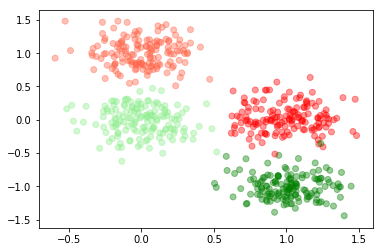

In [2]:
Xs, ys = make_blobs(300, centers=[[0, 0], [0, 1]], cluster_std=0.2)
Xt, yt = make_blobs(300, centers=[[1, -1], [1, 0]], cluster_std=0.2)

plt.scatter(Xs[:,0], Xs[:,1], c=[["lightgreen", "tomato"][k] for k in ys], alpha=0.4)
plt.scatter(Xt[:,0], Xt[:,1], c=[["g", "red"][k] for k in yt],  alpha=0.4)

Note that during training we don't have access to the target dataset labels, so our data looks something like this

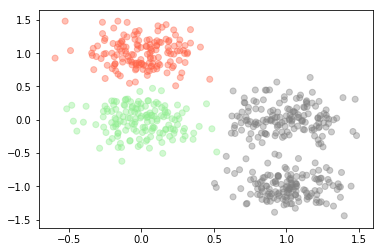

In [3]:
plt.scatter(Xs[:,0], Xs[:,1], c=[["lightgreen", "tomato"][k] for k in ys], alpha=0.4)
plt.scatter(Xt[:,0], Xt[:,1], c=[["gray", "gray"][k] for k in yt],  alpha=0.4)

In [4]:
def build_models(n_neurons):
    """Creates three different models, one used for source only training, two used for domain adaptation"""
    inputs = Input(shape=(2,)) 
    x4 = Dense(n_neurons, activation='linear')(inputs)
    x4 = BatchNormalization()(x4)
    x4 = Activation("elu")(x4)  

    source_classifier = Dense(2, activation='softmax', name="mo")(x4)  
    domain_classifier = Dense(32, activation='linear', name="do4")(x4)
    domain_classifier = BatchNormalization(name="do5")(domain_classifier)
    domain_classifier = Activation("elu", name="do6")(domain_classifier)
    domain_classifier = Dropout(0.5)(domain_classifier)

    domain_classifier = Dense(2, activation='softmax', name="do")(domain_classifier)

    comb_model = Model(inputs=inputs, outputs=[source_classifier, domain_classifier])
    comb_model.compile(optimizer="Adam",
              loss={'mo': 'categorical_crossentropy', 'do': 'categorical_crossentropy'},
              loss_weights={'mo': 1, 'do': 2}, metrics=['accuracy'], )

    source_classification_model = Model(inputs=inputs, outputs=[source_classifier])
    source_classification_model.compile(optimizer="Adam",
              loss={'mo': 'categorical_crossentropy'}, metrics=['accuracy'], )


    domain_classification_model = Model(inputs=inputs, outputs=[domain_classifier])
    domain_classification_model.compile(optimizer="Adam",
                  loss={'do': 'categorical_crossentropy'}, metrics=['accuracy'])
    
    
    embeddings_model = Model(inputs=inputs, outputs=[x4])
    embeddings_model.compile(optimizer="Adam",loss = 'categorical_crossentropy', metrics=['accuracy'])
                        
                        
    return comb_model, source_classification_model, domain_classification_model, embeddings_model

def batch_generator(data, batch_size):
    """Generate batches of data.

    Given a list of numpy data, it iterates over the list and returns batches of the same size
    This
    """
    all_examples_indices = len(data[0])
    while True:
        mini_batch_indices = np.random.choice(all_examples_indices, size=batch_size, replace=False)
        tbr = [k[mini_batch_indices] for k in data]
        yield tbr






Train function takes source and target information and train the network. Note that target labels are not used for training

In [5]:
#SAMPLING_ITERATIONS = 3000

def train(Xs, ys, Xt, yt,  enable_dann = True, n_iterations = 15000):
    
    batch_size = 64
    
    model, source_classification_model, domain_classification_model, embeddings_model = build_models(2)

    y_class_dummy = np.ones((len(Xt), 2))
    y_adversarial_1 = to_categorical(np.array(([1] * batch_size + [0] * batch_size)))
    
    sample_weights_class = np.array(([1] * batch_size + [0] * batch_size))
    sample_weights_adversarial = np.ones((batch_size * 2,))

    S_batches = batch_generator([Xs, to_categorical(ys)], batch_size)
    T_batches = batch_generator([Xt, np.zeros(shape = (len(Xt),2))], batch_size)
    
    for i in range(n_iterations):
        # # print(y_class_dummy.shape, ys.shape)
        y_adversarial_2 = to_categorical(np.array(([0] * batch_size + [1] * batch_size)))

        X0, y0 = next(S_batches)
        X1, y1 = next(T_batches)


        X_adv = np.concatenate([X0, X1])
        y_class = np.concatenate([y0, np.zeros_like(y0)])

        adv_weights = []
        for layer in model.layers:
            if (layer.name.startswith("do")):
                adv_weights.append(layer.get_weights())

        if(enable_dann):
            # note - even though we save and append weights, the batchnorms moving means and variances
            # are not saved throught this mechanism 
            stats = model.train_on_batch(X_adv, [y_class, y_adversarial_1],
                                     sample_weight=[sample_weights_class, sample_weights_adversarial])
            
            k = 0
            for layer in model.layers:
                if (layer.name.startswith("do")):
                    layer.set_weights(adv_weights[k])
                    k += 1

            class_weights = []
            
        
            for layer in model.layers:
                if (not layer.name.startswith("do")):
                    class_weights.append(layer.get_weights())
            
            stats2 = domain_classification_model.train_on_batch(X_adv, [y_adversarial_2])

            k = 0
            for layer in model.layers:
                if (not layer.name.startswith("do")):
                    layer.set_weights(class_weights[k])
                    k += 1

        else:
            source_classification_model.train_on_batch(X0,y0)
            
       
        if ((i + 1) % 1000 == 0):
            # print(i, stats)
            y_test_hat_t = source_classification_model.predict(Xt).argmax(1)
            y_test_hat_s = source_classification_model.predict(Xs).argmax(1)
            print("Iteration %d, source accuracy =  %.3f, target accuracy = %.3f"%(i, accuracy_score(ys, y_test_hat_s), accuracy_score(yt, y_test_hat_t)))
    return embeddings_model

In [6]:
embs = train(Xs, ys, Xt, yt, enable_dann = False)

Iteration 999, source accuracy =  0.993, target accuracy = 0.507
Iteration 1999, source accuracy =  0.997, target accuracy = 0.523
Iteration 2999, source accuracy =  1.000, target accuracy = 0.520
Iteration 3999, source accuracy =  1.000, target accuracy = 0.530
Iteration 4999, source accuracy =  1.000, target accuracy = 0.520
Iteration 5999, source accuracy =  1.000, target accuracy = 0.507
Iteration 6999, source accuracy =  1.000, target accuracy = 0.510
Iteration 7999, source accuracy =  1.000, target accuracy = 0.520
Iteration 8999, source accuracy =  1.000, target accuracy = 0.507
Iteration 9999, source accuracy =  1.000, target accuracy = 0.507
Iteration 10999, source accuracy =  1.000, target accuracy = 0.520
Iteration 11999, source accuracy =  1.000, target accuracy = 0.523
Iteration 12999, source accuracy =  1.000, target accuracy = 0.510
Iteration 13999, source accuracy =  1.000, target accuracy = 0.520
Iteration 14999, source accuracy =  1.000, target accuracy = 0.507


We can now plot the embedding layer activations - note that the process is not deterministic  -notice how it's impossible to learn a linear classifier that is sucessfull in both datasets using the features learned.

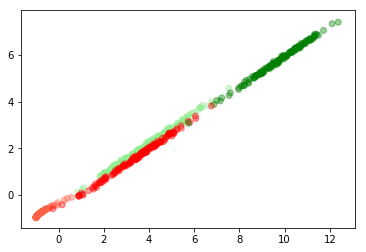

In [7]:
Xs_act = embs.predict(Xs)
Xt_act = embs.predict(Xt)


plt.scatter(Xs_act[:,0], Xs_act[:,1], c=[["lightgreen", "tomato"][k] for k in ys], alpha=0.4)
plt.scatter(Xt_act[:,0], Xt_act[:,1], c=[["g", "red"][k] for k in yt],  alpha=0.4)

In [8]:
embs = train(Xs, ys, Xt, yt, enable_dann = True)

Iteration 999, source accuracy =  0.993, target accuracy = 0.750
Iteration 1999, source accuracy =  0.977, target accuracy = 0.960
Iteration 2999, source accuracy =  0.977, target accuracy = 0.963
Iteration 3999, source accuracy =  0.977, target accuracy = 0.963
Iteration 4999, source accuracy =  0.977, target accuracy = 0.963
Iteration 5999, source accuracy =  0.980, target accuracy = 0.960
Iteration 6999, source accuracy =  0.977, target accuracy = 0.963
Iteration 7999, source accuracy =  0.983, target accuracy = 0.960
Iteration 8999, source accuracy =  0.977, target accuracy = 0.963
Iteration 9999, source accuracy =  0.983, target accuracy = 0.963
Iteration 10999, source accuracy =  0.977, target accuracy = 0.963
Iteration 11999, source accuracy =  0.977, target accuracy = 0.963
Iteration 12999, source accuracy =  0.983, target accuracy = 0.960
Iteration 13999, source accuracy =  0.977, target accuracy = 0.963
Iteration 14999, source accuracy =  0.983, target accuracy = 0.960


Again, we can plot the activations - note that the activations learned between runs can be quite different, but notice the collapse of all green and red dots into similiar regions

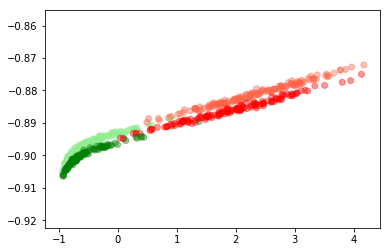

In [9]:
Xs_act = embs.predict(Xs)
Xt_act = embs.predict(Xt)


plt.scatter(Xs_act[:,0], Xs_act[:,1], c=[["lightgreen", "tomato"][k] for k in ys], alpha=0.4)
plt.scatter(Xt_act[:,0], Xt_act[:,1], c=[["g", "red"][k] for k in yt],  alpha=0.4)